# Exercise 6.1: SIR model

[The SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) is a simple mathematical model to simulate epidemics. The population is divided into three groups: **S**usceptible, **I**nfectious and **R**emoved (recovered or dead). The size of the respective groups is given as functions of time $S(t)$, $I(t)$ and $R(t)$. It is also assumed that there is an infection rate $\beta$ and a recovery/death rate $\gamma$. Then the model is defined by the following differential equations:

$$\dfrac{dS}{dt} = -\beta I S, \quad \dfrac{dI}{dt} = \beta I S - \gamma I, \quad \dfrac{dR}{dt} = \gamma I$$

**a)** Plot $S, I$ an $R$ for $\beta=0.4$ and $\gamma=0.04$ for $t\in[0,100]$ and initial conditions $S(0)=0.997$, $I(0)=0.03$ and $R(0)=0$ (you can use `scipy.integrate.solve_ivp` function). Add all the necessary captions to the plot.

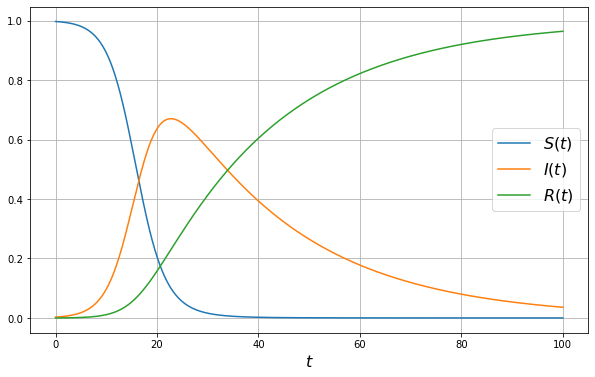

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt


# We need to define the right hand side of the system as a function fun(t,y, args) to use scipy.integrate.solve_ivp
# Here t is a scalar time and y is the vector of the system state 
# y has shape (3,) and contains variables S,I,R in our case
# The function should also return a (3,) vector 
# (see documentation of scipy.integrate.solve_ivp)
def sir(t,y,beta,gamma):
    s,i,r=y
    return [-beta*s*i, beta*s*i-gamma*i, gamma*i]

# Set the parameters
s_0, i_0, r_0, beta, gamma = 0.997, 0.003, 0, 0.4, 0.04

# Solve the ODE
sol = integrate.solve_ivp(sir, [0,100],[s_0,i_0,r_0],
                          t_eval=np.linspace(0,100,10000), args=(beta,gamma))

# Plot the results

fig, ax = plt.subplots(figsize=(10,6))

# sol.y.T contains all the 3 lines 
plt.plot(sol.t, sol.y.T[:,0], label = '$S(t)$')
plt.plot(sol.t, sol.y.T[:,1], label = '$I(t)$')
plt.plot(sol.t, sol.y.T[:,2], label = '$R(t)$')

plt.xlabel('$t$', fontsize=16)

plt.legend(fontsize=16)
plt.grid()

**b)** Determine the point with the maximum fraction of infectious individuals and mark this point in the plot.

The maximal number of infectios people is 0.67 and is achieved at time t=22.74.


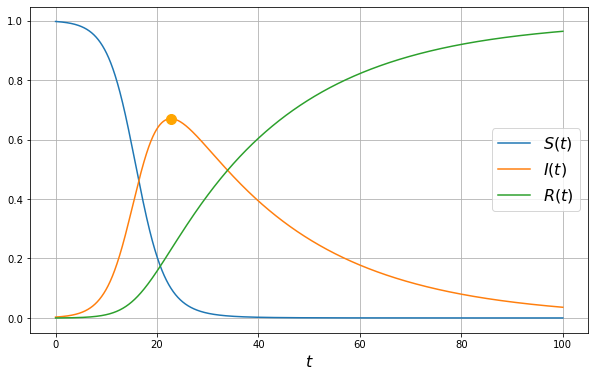

In [2]:
# There are many ways to find the maximum of I(t)
# First option: use numpy.argmax 

from scipy import optimize

t_max = np.argmax(sol.y[1])
print(f"The maximal number of infectios people is {sol.y[1,t_max]:0.2f} and is achieved at time t={sol.t[t_max]:0.2f}.")

# We can now add this point to the figure

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(sol.t, sol.y.T[:,0], label = '$S(t)$')
plt.plot(sol.t, sol.y.T[:,1], label = '$I(t)$')
plt.plot(sol.t, sol.y.T[:,2], label = '$R(t)$')

plt.xlabel('$t$', fontsize=16)

plt.legend(fontsize=16)
plt.grid()

plt.plot(sol.t[t_max],sol.y[1,t_max],'o', color='orange', markersize=10)

In [3]:
# Alternatively, we can define an event to be tracked by scipy.integrate.solve_ivp
# An event should be defined as a function that reaches 0 iff the event of interest happens (see documentation)
# Since we are looking for a maximum, we can track the event when the derivative of I(t) is zero
def event_max(t,y,beta,gamma):
    return sir(t,y,beta,gamma)[1]

# We now solve the ODE again with argument events = event_max
sol = integrate.solve_ivp(sir, [0,100],[s_0,i_0,r_0], 
                          t_eval=np.linspace(0,100,10000), args=(beta,gamma), events = event_max)

# Now the events are returned as sol.t_events, sol.y_events
print(f"The maximal number of infectios people is {sol.y_events[0][0][1]:0.2f} and is achieved at time t={sol.t_events[0][0]:0.2f}.")

The maximal number of infectios people is 0.67 and is achieved at time t=22.74.


In [4]:
# The maximum can also be determined theoretically (see e.g. wikipedia on SIR model)
rho = gamma/beta
print(f"The theoretical solution: {1-rho+rho*np.log(rho/s_0)}.")

The theoretical solution: 0.6700419416026253.


**c)** Determine the maximal infection rate $\beta'$ such that for $\gamma=0.04$ and all $\beta\leq\beta'$ the epidemic does not break out, i.e. $I(t) < I(0)$ for any $t>0$.

In [5]:
# We use binary search to find the maximal infection rate beta'
# To do so, we start with a reasonable interval [l,r], e.g. [0,0.4]
# Check whether the infection is still breaking out in the center m=(l+r)/2 or not
# If the infection still breaks out, then beta' < m and we can restrict the interval to [l,m]
# If the infection no longer breaks out, then beta > m and we restrict to [m,r].
# We repeat these procedure until the desired accuracy is achieved (each step reduces the error by factor 1/2)

beta_upper = 0.4
beta_lower = 0
eps = 10**-8

while abs(beta_upper-beta_lower) > eps:
    # define the middle point
    beta=(beta_lower+beta_upper)/2
    # Solve the ODE with beta = (beta_lower+beta_upper)/2
    sol = integrate.solve_ivp(sir, [0,eps],[s_0,i_0,r_0], args=(beta,gamma),max_step=0.001 )
    # If the infection breaks out, the end value is greater than the starting value
    # If this is not the case, the infection does not break out
    if sol.y[1][-1]>sol.y[1][0]:
        beta_upper = beta
    else:
        beta_lower = beta

        
print(f"The found maximal infection rate such that the epidemic does not break out: {beta_upper}")

# We can compare with the theoretical solution (see e.g. wiki on SIR model)
print(f"The theoretical solution: {gamma/s_0}")

The found maximal infection rate such that the epidemic does not break out: 0.04012036919593812
The theoretical solution: 0.04012036108324975


# Exercise 6.2: Anscombe's quartet 

[Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) comprises four data sets that have nearly identical simple descriptive statistics, yet have very different distributions and appear very different when graphed. The goal of these task is to investigate these datasets.

**a)** Load these datasets from `Anscombe.txt` file and store them in appropriate numpy arrays (you can use `numpy.loadtxt` function).

In [6]:
anscombe = np.loadtxt('Anscombe.txt')
# The file Anscombe.txt must be saved in the working directory (the one with the Jupyter notebook)

anscombe

array([[ 4.  ,  4.26,  4.  ,  3.1 ,  4.  ,  5.39,  8.  ,  5.25],
       [ 5.  ,  5.68,  5.  ,  4.74,  5.  ,  5.73,  8.  ,  5.56],
       [ 6.  ,  7.24,  6.  ,  6.13,  6.  ,  6.08,  8.  ,  5.76],
       [ 7.  ,  4.82,  7.  ,  7.26,  7.  ,  6.42,  8.  ,  6.58],
       [ 8.  ,  6.95,  8.  ,  8.14,  8.  ,  6.77,  8.  ,  6.89],
       [ 9.  ,  8.81,  9.  ,  8.77,  9.  ,  7.11,  8.  ,  7.04],
       [10.  ,  8.04, 10.  ,  9.14, 10.  ,  7.46,  8.  ,  7.71],
       [11.  ,  8.33, 11.  ,  9.26, 11.  ,  7.81,  8.  ,  7.91],
       [12.  , 10.84, 12.  ,  9.13, 12.  ,  8.15,  8.  ,  8.47],
       [13.  ,  7.58, 13.  ,  8.74, 13.  , 12.74,  8.  ,  8.84],
       [14.  ,  9.96, 14.  ,  8.1 , 14.  ,  8.84, 19.  , 12.5 ]])

**b)** Compare the statistical characteristics of the four datasets: expected value (`np.mean`) and variance (`np.var`) .

In [7]:
mean = np.mean(anscombe, axis = 0) # calculates the expected value column by column

for i in range(0,8,2):
    print(f"Dataset {i//2}, x-mean : {mean[i]:.2f}")
    print(f"Dataset {i//2}, y-mean : {mean[i+1]:.2f}")
    print()

Dataset 0, x-mean : 9.00
Dataset 0, y-mean : 7.50

Dataset 1, x-mean : 9.00
Dataset 1, y-mean : 7.50

Dataset 2, x-mean : 9.00
Dataset 2, y-mean : 7.50

Dataset 3, x-mean : 9.00
Dataset 3, y-mean : 7.50



In [8]:
mean = np.var(anscombe, axis = 0) # calculates the variance column by column

for i in range(0,8,2):
    print(f"Dataset {i//2}, x-variance : {mean[i]:.2f}")
    print(f"Dataset {i//2}, y-variance : {mean[i+1]:.2f}")
    print()

Dataset 0, x-variance : 10.00
Dataset 0, y-variance : 3.75

Dataset 1, x-variance : 10.00
Dataset 1, y-variance : 3.75

Dataset 2, x-variance : 10.00
Dataset 2, y-variance : 3.75

Dataset 3, x-variance : 10.00
Dataset 3, y-variance : 3.75



**c)** Determine the linear regression line for each data set and plot the data sets with lines (you can use e.g. `np.polyfit` function). What do you notice?

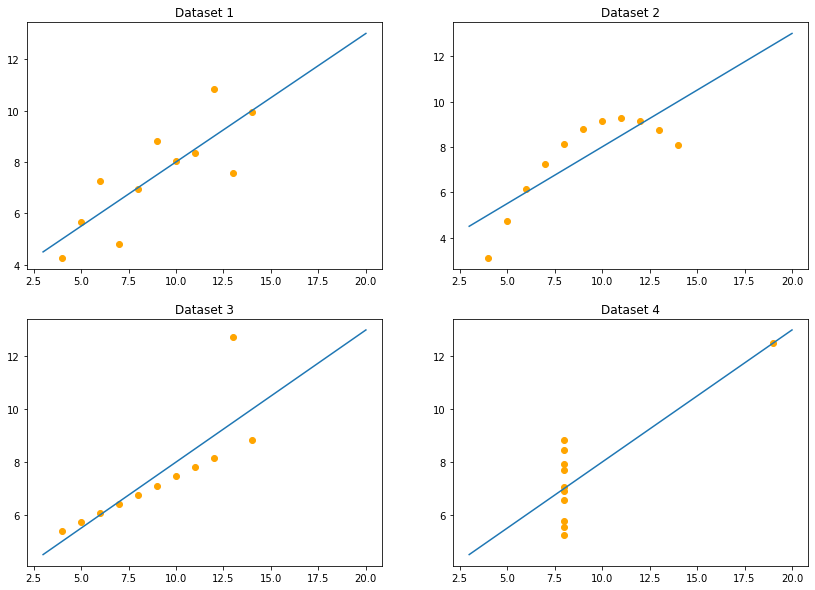

In [9]:
fig, ax = plt.subplots(2,2, figsize = (14,10))

for i, ax_ in zip(range(0,8,2),ax.ravel()):
    # scatter plot the points of each dataset
    ax_.scatter(anscombe.T[i],anscombe.T[i+1], color = 'orange')
    
    # fit a linear regression curve 
    a, b = np.polyfit(anscombe.T[i],anscombe.T[i+1],1)
    # plot the linear regression line as b+at
    t = np.linspace(3,20)
    ax_.plot(t, b+t*a)
    
    ax_.set_title(f'Dataset {i//2+1}')